# ENV/ATM 415: Climate Laboratory

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 9: Radiative-Convective Equilibrium

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log
import climlab
from metpy.plots import SkewT

In [2]:
# This will try to read the data over the internet.
temperature_filename = 'air.mon.1981-2010.ltm.nc'  # temperature
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
#  Open handle to data
ncep_air = xr.open_dataset(ncep_url + temperature_filename, decode_times=False)

In [3]:
#  Take global, annual average and convert to Kelvin
weight = cos(deg2rad(ncep_air.lat)) / cos(deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
print( Tglobal)

<xarray.DataArray (level: 17)>
array([ 15.179082,  11.207002,   7.838327,   0.219941,  -6.448343, -14.888844,
       -25.570467, -39.369685, -46.797908, -53.652235, -60.563551, -67.006048,
       -65.532927, -61.486637, -55.853581, -51.593945, -43.219982])
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 600.0 500.0 400.0 ...


In [4]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

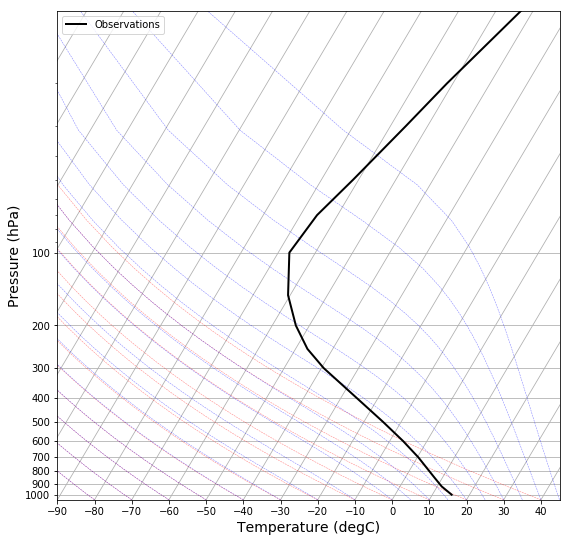

In [5]:
skew = make_skewT()

In [6]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)

In [7]:
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))

In [8]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
state

{'Tatm': Field([ 200.  ,  203.12,  206.24,  209.36,  212.48,  215.6 ,  218.72,
         221.84,  224.96,  228.08,  231.2 ,  234.32,  237.44,  240.56,
         243.68,  246.8 ,  249.92,  253.04,  256.16,  259.28,  262.4 ,
         265.52,  268.64,  271.76,  274.88,  278.  ]), 'Ts': Field([ 288.])}

In [9]:
rad = climlab.radiation.RRTMG(name='Radiation (all gases)',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,
                             )
print(rad)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiation (all gases): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



In [10]:
conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=state,
                                               adj_lapse_rate=6.5,
                                               timestep=climlab.constants.seconds_per_day,
                                              )
print(conv)

climlab Process of type <class 'climlab.convection.convadj.ConvectiveAdjustment'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [11]:
rcmodel = rad + conv
rcmodel.name = 'Radiative-Convective Model'
print(rcmodel)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiative-Convective Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation (all gases): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [12]:
rcmodel.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.99942230115 years.


In [13]:
rcmodel.ASR - rcmodel.OLR

Field([ -3.12861590e-06])

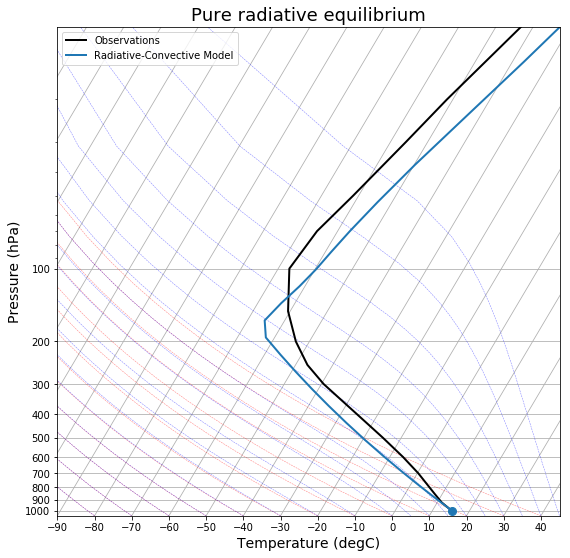

In [14]:
skew = make_skewT()
add_profile(skew, rcmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

In [15]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
rad = climlab.radiation.RRTMG(name='all gases',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )

rad_noO3 = climlab.process_like(rad)
rad_noO3.absorber_vmr['O3'] *= 0.
rad_noO3.name = 'no O3'

rad_noH2O = climlab.process_like(rad)
rad_noH2O.specific_humidity *= 0.
rad_noH2O.name = 'no H2O'

rad_noO3_noH2O = climlab.process_like(rad_noO3)
rad_noO3_noH2O.specific_humidity *= 0.
rad_noO3_noH2O.name = 'no O3, no H2O'

rad_models = [rad, rad_noO3, rad_noH2O, rad_noO3_noH2O]

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [16]:
for model in rad_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

In [17]:
rc_models = []
for r in rad_models:
    newrad = climlab.process_like(r)
    conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=newrad.state,
                                               adj_lapse_rate=6.5,
                                               timestep=newrad.timestep,)
    rc = newrad + conv
    rc.name = newrad.name
    rc_models.append(rc)

In [18]:
for model in rc_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

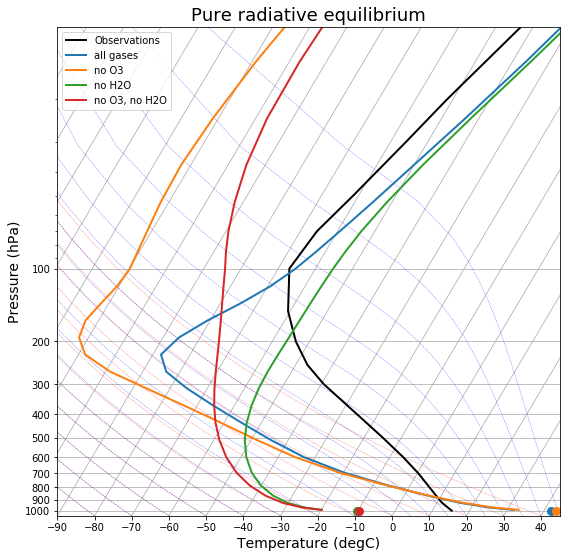

In [19]:
skew = make_skewT()
for model in rad_models:
    add_profile(skew, model)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

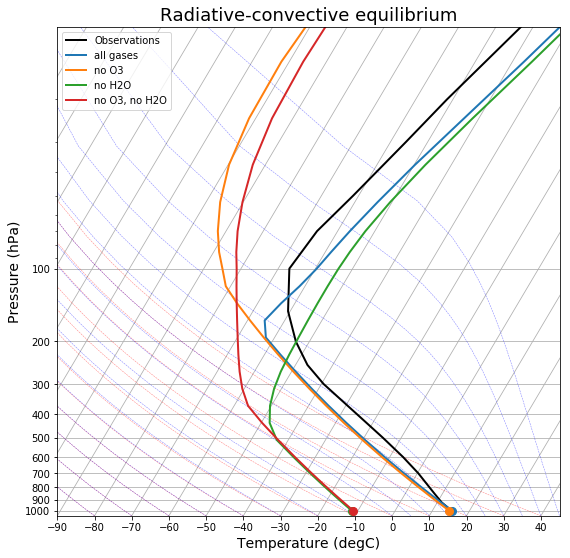

In [20]:
skew = make_skewT()
for model in rc_models:
    add_profile(skew, model)
skew.ax.set_title('Radiative-convective equilibrium', fontsize=18);

## Adjustment to equilibrium

In [21]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
rad = climlab.radiation.RRTMG(name='Radiation (net)',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=newrad.state,
                                               adj_lapse_rate=6.5,
                                               timestep=newrad.timestep,)
rcm = rad + conv
rcm.name = 'Radiative-Convective Model'

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [22]:
def get_tendencies(model):
    '''Pack all the subprocess tendencies into xarray.Datasets
    and convert to units of K / day'''
    tendencies_atm = xr.Dataset()
    tendencies_sfc = xr.Dataset()
    for name, proc, top_proc in climlab.utils.walk.walk_processes(model, topname='Total', topdown=False):
        tendencies_atm[name] = proc.tendencies['Tatm'].to_xarray()
        tendencies_sfc[name] = proc.tendencies['Ts'].to_xarray()
    for tend in [tendencies_atm, tendencies_sfc]:
        #  convert to K / day
        tend *= climlab.constants.seconds_per_day
    return tendencies_atm, tendencies_sfc

In [23]:
def initial_figure(model):
    fig = plt.figure(figsize=(14,6))
    lines = []
    
    skew = SkewT(fig, subplot=(1,2,1), rotation=30)
    lines.append(skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK, 
              color='black', linestyle='-', linewidth=2,)[0])
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 65)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    skew.ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    lines.append(skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
                  markersize=8, color='black')[0])

    ax = fig.add_subplot(1,2,2, sharey=skew.ax)
    ax.set_ylim(1050, 10)
    ax.grid()
    ax.set_xlabel('Temperature tendency ($^\circ$C day$^{-1}$)', fontsize=14)

    color_cycle=['g','b','r','y','k']
    #color_cycle=['y', 'r', 'b', 'g', 'k']
    tendencies_atm, tendencies_sfc = get_tendencies(rcm)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines.append(ax.plot(tendencies_atm[name], model.lev, label=name, color=color_cycle[i])[0])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines.append(ax.plot(tendencies_sfc[name], 1000, 'o', markersize=8, color=color_cycle[i])[0])
    ax.legend(loc='center right');
    lines.append(skew.ax.text(-120, 50, 'Day {}'.format(int(model.time['days_elapsed'])), fontsize=12)) 
    return fig, lines

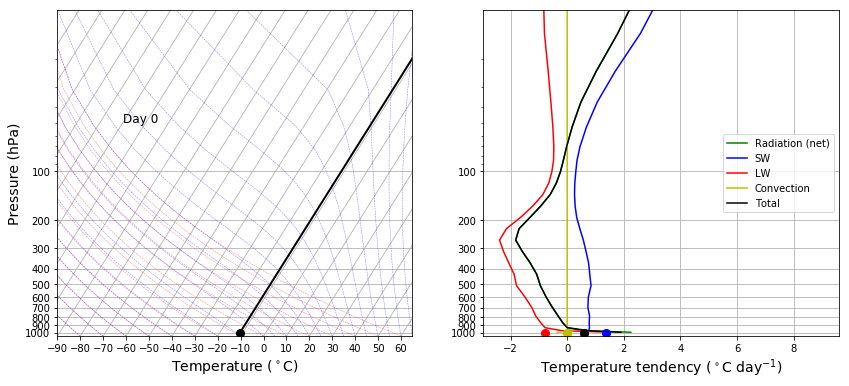

In [24]:
#  Start from isothermal state
rcm.state.Tatm[:] = rcm.state.Ts
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm)

In [25]:
def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm)-climlab.constants.tempCtoK)
    lines[1].set_xdata(np.array(model.Ts)-climlab.constants.tempCtoK)
    #lines[2].set_xdata(np.array(model.q)*1E3)
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines[2+i].set_xdata(tendencies_atm[name])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines[2+5+i].set_xdata(tendencies_sfc[name])
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines   

In [26]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

In [27]:
ani = animation.FuncAnimation(fig, animate, 300, fargs=(rcm, lines))

In [28]:
HTML(ani.to_html5_video())